In [29]:
import pandas as pd  
import sqlite3


conn = sqlite3.connect("Database/database.sqlite")


df_teams = pd.read_sql_query("SELECT * FROM team;", conn)
df_countries = pd.read_sql_query("SELECT * FROM country;", conn)
df_matchs = pd.read_sql_query("SELECT * FROM match;", conn)
df_leagues = pd.read_sql_query("SELECT * FROM league;", conn)
df_player = pd.read_sql_query("SELECT * FROM player;", conn)
df_player_attribute = pd.read_sql_query("SELECT * FROM Player_Attributes;", conn)
df_teams_attributes=pd.read_sql_query("select * from team_attributes;",conn)

df_matchs=df_matchs.drop(columns=['B365H','B365D','B365A','BWH','BWD','BWA','IWH','IWD','IWA','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','SJH','SJD','SJA','VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD','BSA'])

conn.close()


#### Création d’une Vue Consolidée

In [3]:
player_team=df_player.merge(df_teams)
player_team_att=player_team.merge(df_player_attribute,on='id')
full_team=pd.merge(player_team,df_teams)

full_team.set_index(keys='id')['team_long_name'].reset_index()
 



,id,team_long_name
0,1,KRC Genk
1,2,Beerschot AC
2,3,SV Zulte-Waregem
3,4,Sporting Lokeren
4,5,KSV Cercle Brugge
...,...,...
78,9556,AS Saint-Étienne
79,10300,RC Lens
80,10309,Montpellier Hérault SC
81,10312,US Boulogne Cote D'Opale


#### Analyse des Joueurs : 
les joueurs les plus performants de chaque saison 

In [4]:
import xml.etree.ElementTree as ET
import pandas as pd
from collections import defaultdict
import pandas as pd

def store_goals_to_dataframe(xml_data,a):
    
    
    # Parse the XML data
    root = ET.fromstring(xml_data)
    goals_list = []

    # Iterate over each 'value' element inside 'goal'
    for value in root.findall('value'):
        goal_data = defaultdict(lambda: None) 

       
        goal_data['goal_id'] = int(value.find('id').text) if value.find('id') is not None else None
        goal_data['team'] = int(value.find('team').text) if value.find('team') is not None else None
        goal_data['player1'] = int(value.find('player1').text) if value.find('player1') is not None else None
        goal_data['player2'] = int(value.find('player2').text) if value.find('player2') is not None else None
        goal_data['elapsed'] = int(value.find('elapsed').text) if value.find('elapsed') is not None else None
        goal_data['goal_type'] = value.find('goal_type').text if value.find('goal_type') is not None else None
        goal_data['goal_subtype'] = value.find('subtype').text if value.find('subtype') is not None else None
        goal_data['goal_comment'] = value.find('comment').text if value.find('comment') is not None else None
        goal_data['event_type'] = int(value.find('event_incident_typefk').text) if value.find('event_incident_typefk') is not None else None
        goal_data['sort_order'] = int(value.find('sortorder').text) if value.find('sortorder') is not None else None
        goal_data['type_goal'] = value.find('type').text if value.find('type') is not None else None
        goal_data['stats'] = value.find('stats') 
        goal_data['match_id']=a
     
        if goal_data['stats'] is not None:
            goal_data['goals'] = int(goal_data['stats'].find('goals').text) if goal_data['stats'].find('goals') is not None else None
        else:
            goal_data['goals'] = None
            
        goals_list.append(goal_data)

    goal_df = pd.DataFrame(goals_list)

    return goal_df



df_without_Nan = df_matchs.dropna(subset=['goal'])
l = df_without_Nan['goal']
all_goals_df = []


for index, value in enumerate(l):
    goal_df = store_goals_to_dataframe(value,df_without_Nan.index[index])
    all_goals_df.append(goal_df)

final_goals_df = pd.concat(all_goals_df, ignore_index=True)



/tmp/ipykernel_5795/135406638.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_goals_df = pd.concat(all_goals_df, ignore_index=True)


In [5]:
df_without_Nan.index[2]



np.int64(1730)

In [6]:
link_match_goal_goalkeepers = pd.merge(final_goals_df, df_matchs, left_on='match_id', right_on='id')
link_match_goal_players = pd.merge(link_match_goal_goalkeepers, df_player, left_on='player1', right_on='player_api_id')


link_match_goal_assists = pd.merge(link_match_goal_goalkeepers, df_player, left_on='player2', right_on='player_api_id')

goal_scorers = link_match_goal_players.groupby(['player_name', 'season'])['goals'].sum().sort_values(ascending=False).reset_index()
assisters = link_match_goal_assists.groupby(['player_name', 'season'])['goals'].sum().sort_values(ascending=False).reset_index()

assisters.rename(columns={
    'goals':'assists'
},inplace=True)
goal_scorers_assists=pd.merge(goal_scorers,assisters,on=['player_name','season'])

goal_scorers_assists

,player_name,season,goals,assists
0,Lionel Messi,2014/2015,43.0,18.0
1,Lionel Messi,2011/2012,40.0,15.0
2,Cristiano Ronaldo,2014/2015,40.0,16.0
3,Luis Suarez,2015/2016,40.0,16.0
4,Zlatan Ibrahimovic,2015/2016,38.0,13.0
...,...,...,...,...
5297,Sven van Beek,2014/2015,0.0,1.0
5298,Stewart Downing,2008/2009,0.0,3.0
5299,Stewart Downing,2011/2012,0.0,2.0
5300,Billy Jones,2011/2012,0.0,1.0


visualization

/tmp/ipykernel_5795/833658751.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_assisters.values, y=best_assisters.index, ax=axes[1], palette='viridis')
/tmp/ipykernel_5795/833658751.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_goals.values, y=best_goals.index, ax=axes[2], palette='Blues')


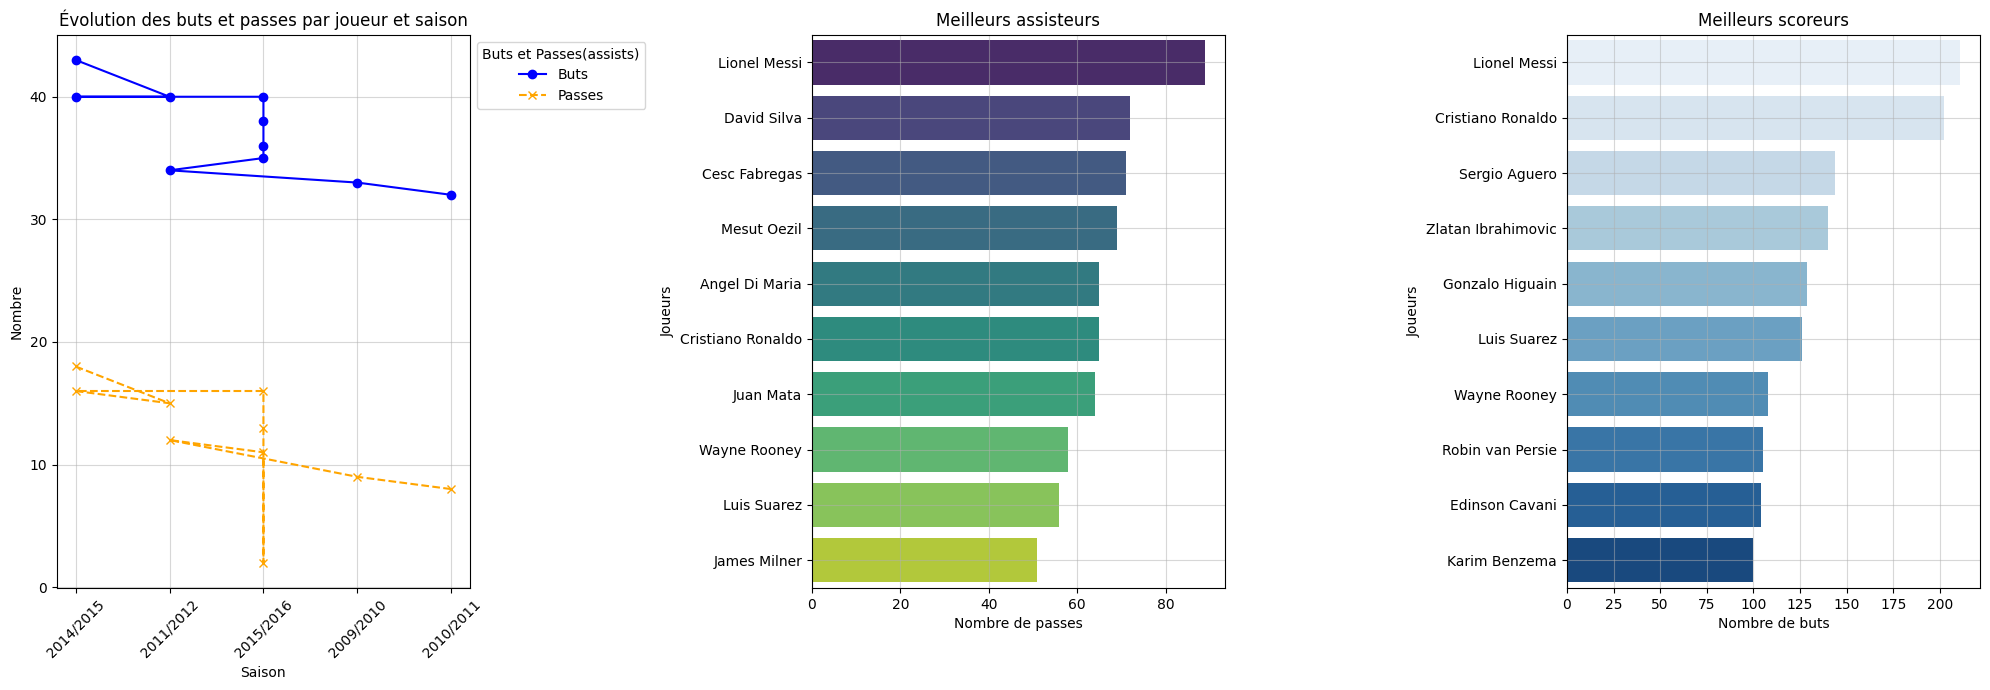

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# premier plot : evolution des buts et assists en function des season
axes[0].plot(goal_scorers_assists['season'].head(10), goal_scorers_assists['goals'].head(10), label='Buts', linestyle='-', marker='o', color='blue')
axes[0].plot(goal_scorers_assists['season'].head(10), goal_scorers_assists['assists'].head(10), label='Passes', linestyle='--', marker='x', color='orange')

axes[0].set_title("Évolution des buts et passes par joueur et saison")
axes[0].set_xlabel("Saison")
axes[0].set_ylabel("Nombre")
axes[0].grid(True, alpha=0.5)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), title="Buts et Passes(assists)")

# Rotate
axes[0].tick_params(axis='x', rotation=45)

# represent des assists par joueurs
best_assisters = goal_scorers_assists.groupby('player_name')['assists'].sum().sort_values(ascending=False).head(10)

sns.barplot(x=best_assisters.values, y=best_assisters.index, ax=axes[1], palette='viridis')

axes[1].set_title("Meilleurs assisteurs")
axes[1].set_xlabel("Nombre de passes")
axes[1].grid(True, alpha=0.5)
axes[1].set_ylabel("Joueurs")

# represent des buts par joueurs
best_goals = goal_scorers_assists.groupby('player_name')['goals'].sum().sort_values(ascending=False).head(10)

sns.barplot(x=best_goals.values, y=best_goals.index, ax=axes[2], palette='Blues')

axes[2].set_title("Meilleurs scoreurs")
axes[2].set_xlabel("Nombre de buts")
axes[2].grid(True, alpha=0.5)
axes[2].set_ylabel("Joueurs")

plt.tight_layout()

plt.show()


==> métrique de performance en combinant la note globale, le potentiel, et d'autres attributs.

In [22]:
player_att=df_player.merge(df_player_attribute,on='player_api_id')
result=player_att.groupby('player_name').agg({
      'potential':'mean',
   'overall_rating':'mean',
   'dribbling':'mean'
   })
result_=result.sort_values(by=['potential','overall_rating','dribbling'],ascending=False).reset_index()
result_['performance_score'] = result_['potential'] + result_['overall_rating'] + result_['dribbling']
top_performers = result_.head(10)
top_performers


,player_name,potential,overall_rating,dribbling,performance_score
0,Lionel Messi,95.230769,92.192308,96.461538,283.884615
1,Cristiano Ronaldo,93.480000,91.280000,92.640000,277.400000
2,Fabio Cannavaro,90.833333,85.166667,52.000000,228.000000
3,Neymar,90.760000,83.800000,91.600000,266.160000
4,Andres Iniesta,90.560000,88.320000,90.080000,268.960000
5,Mario Goetze,90.147059,83.176471,88.617647,261.941176
6,Zlatan Ibrahimovic,90.047619,88.285714,89.380952,267.714286
7,Roy Makaay,90.000000,78.333333,71.333333,239.666667
8,James Rodriguez,89.954545,83.000000,85.000000,257.954545
9,Franck Ribery,89.916667,88.458333,92.916667,271.291667


/tmp/ipykernel_5795/162360998.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='performance_score', y='player_name', data=top_performers, palette='viridis')


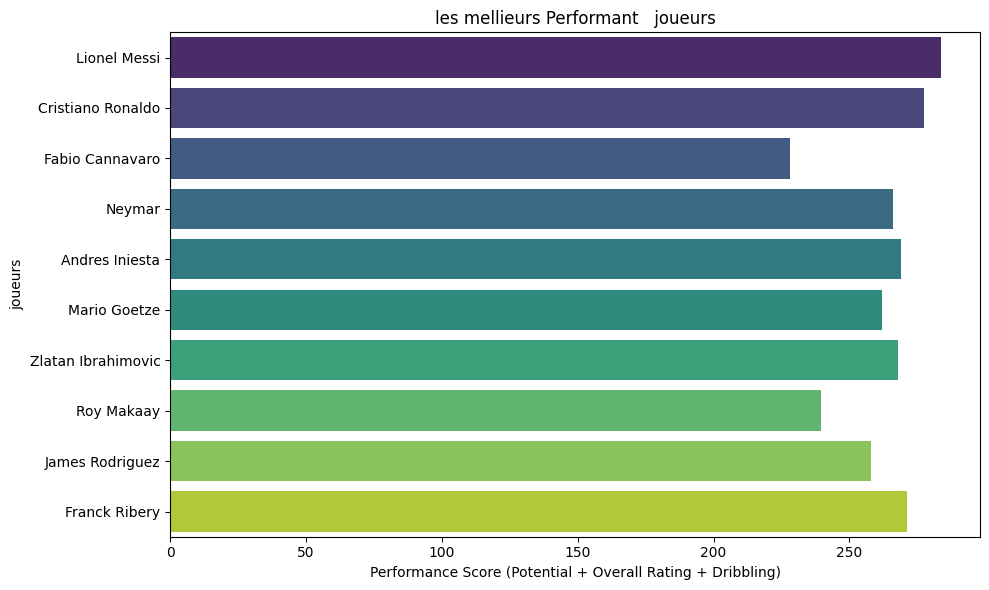

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='performance_score', y='player_name', data=top_performers, palette='viridis')

# Add titles and labels
plt.title("les mellieurs Performant   joueurs")
plt.xlabel("Performance Score (Potential + Overall Rating + Dribbling)")
plt.ylabel("joueurs")

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:

sns.barplot(x=best_goals.values, y=best_goals.index, ax=axes[2], palette='Blues')

axes[2].set_title("Meilleurs scoreurs")
axes[2].set_xlabel("Nombre de buts")
axes[2].grid(True, alpha=0.5)
axes[2].set_ylabel("Joueurs")

plt.tight_layout()


equipe +++++++++++

In [55]:

df_leagues.columns
result=pd.merge(df_matchs,df_leagues,left_on='league_id',right_on='id')

result=result.merge(final_goals_df,left_on='id_x',right_on='match_id')
result_=result.groupby(['name','team'])['goals'].sum().reset_index().sort_values(by='goals',ascending=False)
result_m=pd.merge(result_,df_teams, left_on='team',right_on='team_api_id',how='inner')
# result_m.rename(columns={
#     'name':'league_name'
# })
# result_m
best_teams = result_m.loc[result_.groupby('name')['goals'].idxmax()]
best_teams


,name,team,goals,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
1,Spain LIGA BBVA,8633.0,778.0,43040,8633,243.0,Real Madrid CF,REA
6,England Premier League,10260.0,523.0,3457,10260,11.0,Manchester United,MUN
60,France Ligue 1,9827.0,228.0,9539,9827,59.0,Girondins de Bordeaux,BOR
93,France Ligue 1,7794.0,150.0,12594,7794,58.0,SC Bastia,BAS
125,Netherlands Eredivisie,8674.0,74.0,26548,8674,1915.0,FC Groningen,GRO
142,Switzerland Super League,9931.0,48.0,49118,9931,896.0,FC Basel,BAS
158,Spain LIGA BBVA,10278.0,33.0,44557,10278,100879.0,Hércules Club de Fútbol,HER
159,Germany 1. Bundesliga,8234.0,33.0,19916,8234,111239.0,FC Ingolstadt 04,ING
179,Switzerland Super League,10190.0,25.0,49479,10190,898.0,FC St. Gallen,GAL
202,Poland Ekstraklasa,2183.0,1.0,31448,2183,1570.0,P. Warszawa,PWA


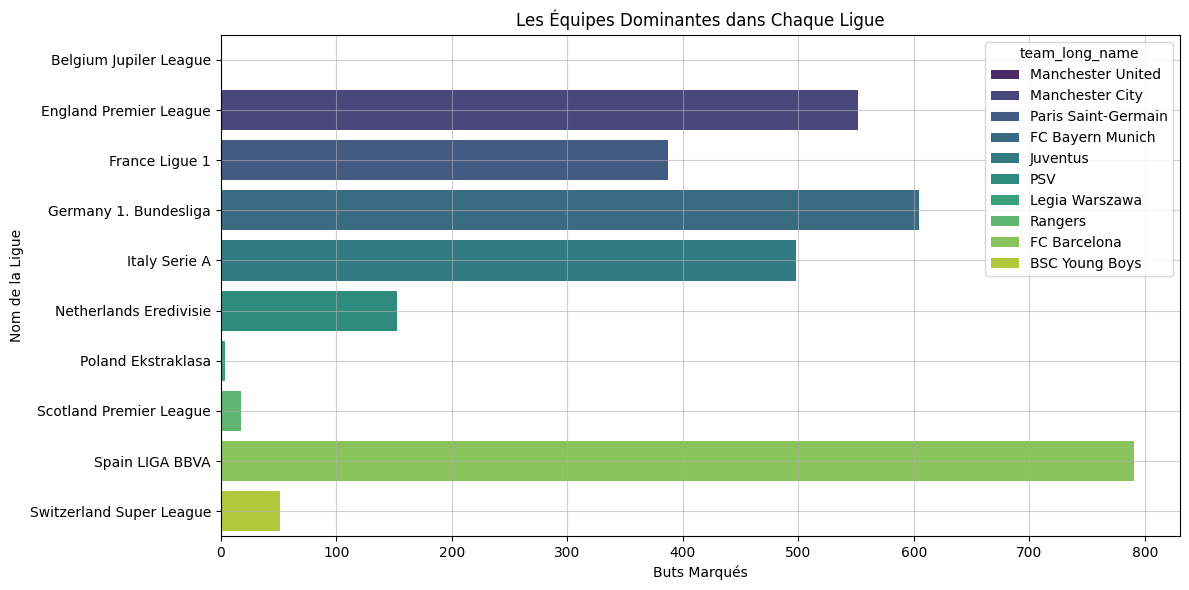

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Regrouper les données par ligue et par équipe pour calculer la somme des buts
result_ = result_m.groupby(['name', 'team_long_name'])['goals'].sum().reset_index()

# Sélectionner l'équipe avec le plus grand nombre de buts dans chaque ligue
best_teams = result_.loc[result_.groupby('name')['goals'].idxmax()]

# Affichage des résultats sous forme de graphique
plt.figure(figsize=(12, 6))
sns.barplot(x='goals', y='name', data=best_teams, hue='team_long_name', palette='viridis')
plt.grid(True,alpha=0.6)
# Ajouter un titre et des labels
plt.title("Les Équipes Dominantes dans Chaque Ligue")
plt.xlabel("Buts Marqués")
plt.ylabel("Nom de la Ligue")

# Afficher le graphique
plt.tight_layout()
plt.show()


In [45]:
def assign_match_results(x):
    # Default values (None) to columns
    x['won_home_team'] = 'won' if x['home_team_goal'] > x['away_team_goal'] else None
    x['won_away_team'] = 'won' if x['home_team_goal'] < x['away_team_goal'] else None
    x['loss_home_team'] = 'loss' if x['home_team_goal'] < x['away_team_goal'] else None
    x['loss_away_team'] = 'loss' if x['home_team_goal'] > x['away_team_goal'] else None
    x['null'] = 1  # null column as None for all cases
    return x

# Apply the function row-wise (axis=1)
df_matchs_add = df_matchs.apply(assign_match_results, axis=1)


In [64]:
away_wins=df_matchs_add.groupby("away_team_api_id").agg({'won_away_team':'count','null':'sum','loss_away_team':'count'}).sort_values(by=['won_away_team','loss_away_team','null'],ascending=False).reset_index()
final_=pd.merge(away_wins,df_teams,left_on='away_team_api_id',right_on='team_api_id')
print("==> Analyse les victoires, défaites, et matchs nuls pour identifier les équipes reteur")
final_

==> Analyse les victoires, défaites, et matchs nuls pour identifier les équipes reteur


,away_team_api_id,won_away_team,null,loss_away_team,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,8634,103,152,18,43042,8634,241.0,FC Barcelona,BAR
1,8633,99,152,28,43040,8633,243.0,Real Madrid CF,REA
2,9925,98,152,27,39395,9925,78.0,Celtic,CEL
3,9885,84,150,30,20522,9885,45.0,Juventus,JUV
4,9823,84,136,22,15617,9823,21.0,FC Bayern Munich,BMU
...,...,...,...,...,...,...,...,...,...
294,4049,1,17,12,15,4049,NaN,Tubize,TUB
295,6631,1,17,12,30222,6631,100626.0,FC Dordrecht,DOR
296,9776,1,17,12,18691,9776,110500.0,Eintracht Braunschweig,BRA
297,6601,1,17,11,26561,6601,NaN,FC Volendam,VOL


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes[0].barplot(final_,x='',y='')

In [ ]:
home_wins=df_matchs_add.groupby(["home_team_api_id","season"]).agg({'won_home_team':'count','loss_home_team':'count','null':'sum'}).sort_values(by=['won_home_team'],ascending=False).reset_index()
final_=pd.merge(home_wins,df_teams,left_on='home_team_api_id',right_on='team_api_id')
print("==> Analyse les victoires, défaites, et matchs nuls pour identifier les équipes allez.")
print("""
      ==> Some teams perform better at home, while others may have stronger away performances.

      """)
final_

==> Analyse les victoires, défaites, et matchs nuls pour identifier les équipes allez.

      ==> Some teams perform better at home, while others may have stronger away performances.

      


,home_team_api_id,season,won_home_team,loss_home_team,null,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,9885,2013/2014,19,0,19,20522,9885,45.0,Juventus,JUV
1,8456,2011/2012,18,0,19,3466,8456,10.0,Manchester City,MCI
2,8634,2012/2013,18,0,19,43042,8634,241.0,FC Barcelona,BAR
3,8634,2009/2010,18,0,19,43042,8634,241.0,FC Barcelona,BAR
4,10260,2010/2011,18,0,19,3457,10260,11.0,Manchester United,MUN
...,...,...,...,...,...,...,...,...,...,...
1476,7869,2014/2015,1,12,19,47612,7869,1867.0,Córdoba CF,COR
1477,8177,2009/2010,1,10,17,15626,8177,166.0,Hertha BSC Berlin,HBE
1478,10215,2014/2015,1,4,17,35292,10215,1901.0,Académica de Coimbra,ACA
1479,8429,2010/2011,1,10,19,39397,8429,184.0,Hamilton Academical FC,HAM


In [134]:
df_teams_attributes.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [167]:
print(df_teams.columns)
print(df_teams_attributes.columns)

full_team_info=pd.merge(df_teams,df_teams_attributes,left_on='team_api_id',right_on='team_api_id')
grouped_data=full_team_info.groupby('team_api_id').agg({
    'buildUpPlaySpeed':'mean',
    'buildUpPlayDribbling':'mean',
    'buildUpPlayPassing':'mean',
    'chanceCreationCrossing':'mean',
    'defenceAggression':'mean',
    'defencePressure':'mean',
    'chanceCreationShooting':'mean'

}).sort_values(by=['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing','chanceCreationCrossing','defenceAggression','chanceCreationShooting','defencePressure'],ascending=False)
grouped_data.reset_index()




Index(['id', 'team_api_id', 'team_fifa_api_id', 'team_long_name',
       'team_short_name'],
      dtype='object')
Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')


,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationCrossing,defenceAggression,defencePressure,chanceCreationShooting
0,9789,72.500000,35.0,46.50,44.500000,69.166667,59.333333,66.333333
1,8600,71.000000,62.5,53.00,64.833333,49.333333,40.666667,54.333333
2,8596,70.000000,NaN,70.00,70.000000,70.000000,60.000000,70.000000
3,158085,67.000000,66.0,39.00,59.000000,38.000000,36.000000,46.000000
4,8178,66.833333,29.5,48.00,55.833333,49.500000,57.666667,53.000000
...,...,...,...,...,...,...,...,...
283,8526,33.500000,NaN,40.50,42.500000,44.000000,47.000000,64.000000
284,2183,32.750000,NaN,44.25,49.750000,40.750000,49.500000,59.250000
285,8242,30.000000,NaN,45.00,40.000000,70.000000,70.000000,70.000000
286,6421,30.000000,NaN,30.00,50.000000,30.000000,30.000000,65.000000


Matchs

In [193]:
df_matchs

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,foulcommit,card,cross,corner,possession,won_home_team,won_away_team,loss_home_team,loss_away_team,null
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,None,None,None,None,None,None,None,None,None,1
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,None,None,None,None,None,None,None,None,None,1
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,None,None,None,None,None,None,won,loss,None,1
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,None,None,None,None,None,won,None,None,loss,1
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,None,None,None,None,None,None,won,loss,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,None,None,None,None,None,won,None,None,loss,1
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,None,None,None,None,None,None,won,loss,None,1
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,None,None,None,None,None,won,None,None,loss,1
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,None,None,None,None,None,None,None,None,None,1


In [209]:
def create_scores(x):
   df_matchs['scores']=df_matchs['away_team_goal']+df_matchs['home_team_goal']
df_matchs.apply(create_scores,axis=1)

df_matchs[['away_team_goal','home_team_goal','scores']].sort_values(by='scores',ascending=False).reset_index()

# attribute_goal 

# 

,index,away_team_goal,home_team_goal,scores
0,24247,2,10,12
1,20106,6,6,12
2,9210,2,9,11
3,23443,3,7,10
4,24122,8,2,10
...,...,...,...,...
25974,2340,0,0,0
25975,23860,0,0,0
25976,23861,0,0,0
25977,23864,0,0,0
